# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## Project Description:

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are
replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.
In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using
Bidirectional LSTMs.

## Dataset:

#### News Headlines dataset for Sarcasm Detection:

The dataset is collected from two news websites, theonion.com and huffingtonpost.com
This new dataset has the following advantages over the existing Twitter datasets.

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements

#### Dataset Decription:

Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

<font color='blue'>*** Importing all necessary libraries and setting the session parameters ***</font>

In [1]:
import os 
print(os.getcwd())

C:\Users\Venkatesh K Govindan\PGP-AIML\Project\Residency-10


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth' , 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid', palette='deep', rc={'figure.figsize':(8,6)})

from scipy import stats

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

<font color='blue'>*** Closing interactive sessions to avoid resource issues ***</font>

In [3]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

<font color='blue'>*** Assigning GPU for the current session ***</font>

In [4]:
import keras
import tensorflow as tf

from tensorflow.python.client import device_lib, session
print(device_lib.list_local_devices())
session.device="GeForce MX250"

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12558371602333882327
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3174265241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17555369726892384298
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


<font color='blue'>*** GPU configuration settings for the session ***</font>

In [5]:
gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
config.gpu_options.allow_growth=True
session=tf.compat.v1.Session(config=config)

### Reading and Exploring Data

#### Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [6]:
sarcasm_df=pd.read_json(path_or_buf='C:/Users/Venkatesh K Govindan/PGP-AIML/Project/Residency-10/Data/Sarcasm_Headlines_Dataset.json',lines=True)

In [7]:
sarcasm_df.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [8]:
sarcasm_df.shape

(26709, 3)

In [9]:
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


<font color='blue'>*** Observation: Sarcasm_Headlines_Dataset has 26709 row and 3 columns, article_link and headline are of Dtype object and is_sarcastic of Dtype int64 ***</font> 

In [10]:
sarcasm_df.sample(5,random_state=99)

,article_link,headline,is_sarcastic
13948,https://www.theonion.com/room-scanned-for-something-to-sell-on-ebay-1819567335,room scanned for something to sell on ebay,1
8831,https://www.huffingtonpost.com/entry/creating-is-about-taking-one-step_b_6375042.html,creating is about taking one step to re-imagining leadership: biting off more than you can chew,0
2666,https://www.huffingtonpost.com/entry/recognizing-the-gift-each-moment-bears-is-_b_6961372.html,recognizing the gift each moment bears is a mindfulness practice,0
8655,https://www.huffingtonpost.com/entry/gummy-bears-send-14-chicago-high-school-students-to-hospita...,gummy bears send 14 chicago-area high school students to hospital,0
3391,https://local.theonion.com/formerly-obese-man-always-showing-everyone-his-old-pant-1819569821,formerly obese man always showing everyone his old pants,1


In [11]:
sarcasm_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

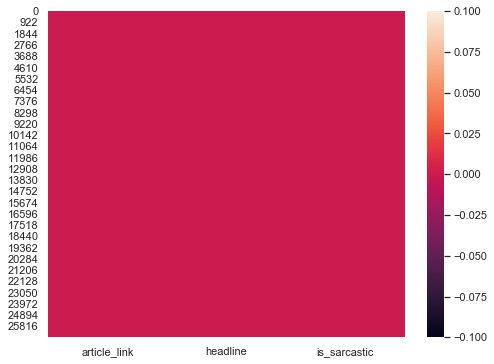

In [12]:
sns.heatmap(sarcasm_df.isna())

<font color='blue'>*** Observation: No Null values in data ***</font> 

In [13]:
sarcasm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_sarcastic,26709.0,0.438953,0.496269,0.0,0.0,0.0,1.0,1.0


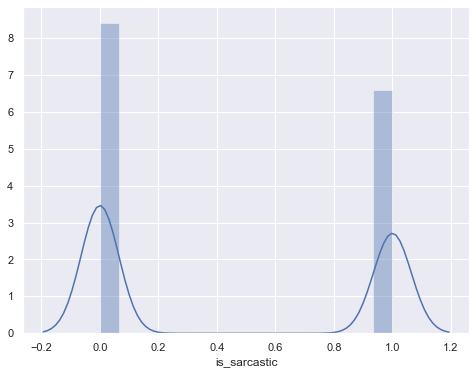

In [14]:
sns.distplot(sarcasm_df['is_sarcastic'])

<font color='blue'>*** Observation: Around 43.89% of data is sarcastic and data is normally distributed with 2 modes (bi-modal) ***</font>

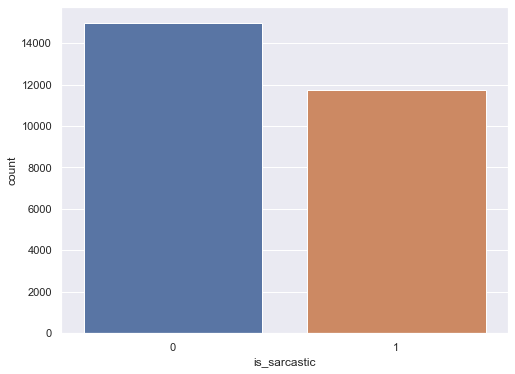

In [15]:
sns.countplot(x='is_sarcastic',data=sarcasm_df)

In [16]:
sarcasm_df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

<font color='blue'>*** Observation: is_sarcastic is a binary class variable, 0 or non-sarcastic data is around 56.10% and 1 or sarcastic is around 43.90% ***</font>

### Drop 'article_link' from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [17]:
sarcasm_df.drop(columns=['article_link'],inplace=True)

In [18]:
sarcasm_df.shape

(26709, 2)

In [19]:
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [20]:
sarcasm_df.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to re-imagining leadership: biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send 14 chicago-area high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** 'headline' column is not having clean test, has special characters, digits..., ***</font>

### Preprocessing 'headline' column to clean the text data

In [21]:
sarcasm_df1=sarcasm_df.copy()

In [22]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to re-imagining leadership: biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send 14 chicago-area high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** Case conversion ***</font>

In [23]:
sarcasm_df1.headline=sarcasm_df1.headline.apply(lambda x : ' '.join( word.lower() for word in x.split()))

In [24]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to re-imagining leadership: biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send 14 chicago-area high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** Removing punctuation characters from text ***</font> 

In [25]:
import re
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
sarcasm_df1.headline=sarcasm_df1.headline.apply(lambda x: x.translate(str.maketrans(' ',' ',string.punctuation)))

In [27]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to reimagining leadership biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send 14 chicagoarea high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** Removing digits from text data ***</font>

In [28]:
sarcasm_df1.headline=sarcasm_df1.headline.str.replace( '[\d]' , '' )

In [29]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to reimagining leadership biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send chicagoarea high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** Remove stopwords which are most commenly used ***</font> <font color='red'>Commented out the stopwords removal logic, since models performance was little better with stopwords included</font> 

In [30]:
from nltk.corpus import stopwords
stopword_list=stopwords.words('english')

In [31]:
print(stopword_list)
print(len(stopword_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
deselect_stop_words=['no', 'nor', 'not']
for i in deselect_stop_words:
    stopword_list.remove(i)
print(stopword_list)
print(len(stopword_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [33]:
#sarcasm_df1.headline=sarcasm_df1.headline.apply(lambda x: ' '.join(word for word in x.split() if word not in stopword_list))

In [34]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to reimagining leadership biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send chicagoarea high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


<font color='blue'>*** Apply Lemmatization to text ***</font> <font color='red'>Commented out the lemmatization logic, since models performance was better without lemmatization</font> 

In [35]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Venkatesh K
[nltk_data]     Govindan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [37]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to reimagining leadership biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send chicagoarea high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


In [38]:
#lemmatized_output=[]
#for text in sarcasm_df1['headline']:
#    word_list=nltk.word_tokenize(text)
#    lemmatized_output.append(' '.join([lemmatizer.lemmatize(w) for w in word_list]))  
#sarcasm_df1['headline']=lemmatized_output

In [39]:
sarcasm_df1.sample(5,random_state=99)

,headline,is_sarcastic
13948,room scanned for something to sell on ebay,1
8831,creating is about taking one step to reimagining leadership biting off more than you can chew,0
2666,recognizing the gift each moment bears is a mindfulness practice,0
8655,gummy bears send chicagoarea high school students to hospital,0
3391,formerly obese man always showing everyone his old pants,1


### Get the Length of each line and find the maximum length. ( 4 marks)
<font color='blue'>As different lines are of different length. We need to pad the our sequences using the max length</font> 

In [40]:
len(sarcasm_df1['headline'][13948])

42

In [41]:
len(sarcasm_df1['headline'][8831])

93

In [42]:
max_len=max([len(line) for line in sarcasm_df1['headline']])
print('Maximum length of a line in data is: %d' %max_len)

Maximum length of a line in data is: 240


## Modelling

### Import required modules required for modelling.

In [43]:
import numpy as np
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

### Set Different Parameters for the model. ( 2 marks)

In [44]:
max_features=10000
maxlen=max_len
embedding_size=200

### Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [45]:
tokenizer=Tokenizer(num_words=max_features, oov_token='unkwn')
tokenizer.fit_on_texts(sarcasm_df1['headline'])

In [46]:
tokenizer.get_config()

{'num_words': 10000,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': 'unkwn',
 'document_count': 26709,
 'word_counts': '{"former": 106, "versace": 1, "store": 46, "clerk": 10, "sues": 17, "over": 476, "secret": 90, "black": 253, "code": 18, "for": 3305, "minority": 15, "shoppers": 3, "the": 5391, "roseanne": 3, "revival": 11, "catches": 14, "up": 765, "to": 8223, "our": 177, "thorny": 3, "political": 83, "mood": 13, "better": 123, "and": 1915, "worse": 40, "mom": 196, "starting": 45, "fear": 46, "sons": 36, "web": 19, "series": 62, "closest": 7, "thing": 144, "she": 197, "will": 556, "have": 492, "grandchild": 2, "boehner": 27, "just": 578, "wants": 138, "wife": 78, "listen": 24, "not": 734, "come": 103, "with": 1801, "alternative": 11, "debtreduction": 1, "ideas": 43, "jk": 7, "rowling": 7, "wishes": 42, "snape": 2, "happy": 62, "birthday": 64, "in": 4187, "most": 259, "magical": 32, "way": 257, "advancing": 2, "w

### Define X and y for your model.

In [47]:
sarcasm_df1[:1]

,headline,is_sarcastic
0,former versace store clerk sues over secret black code for minority shoppers,0


In [48]:
X=tokenizer.texts_to_sequences(sarcasm_df1['headline'])
X=pad_sequences(X,maxlen=maxlen)
y=np.asarray(sarcasm_df1['is_sarcastic'])
print("Number of Samples: %d" %len(X))
print(X[0])
print(' ')
print("Number of Labels: %d" %len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

### Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [49]:
word_index=tokenizer.word_index

In [50]:
print('Length of Tokens: %d' %len(word_index))
print(' ')
print(word_index)

Length of Tokens: 27654
 
{'unkwn': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'from': 15, 'at': 16, 'about': 17, 'you': 18, 'this': 19, 'by': 20, 'after': 21, 'be': 22, 'how': 23, 'out': 24, 'it': 25, 'that': 26, 'as': 27, 'up': 28, 'not': 29, 'are': 30, 'your': 31, 'what': 32, 'his': 33, 'he': 34, 'just': 35, 'who': 36, 'us': 37, 'has': 38, 'will': 39, 'more': 40, 'all': 41, 'into': 42, 'report': 43, 'one': 44, 'why': 45, 'have': 46, 'area': 47, 'over': 48, 'donald': 49, 'says': 50, 'day': 51, 'woman': 52, 'can': 53, 'its': 54, 'time': 55, 'no': 56, 'first': 57, 'like': 58, 'get': 59, 'her': 60, 'trumps': 61, 'people': 62, 'an': 63, 'i': 64, 'now': 65, 'obama': 66, 'house': 67, 'off': 68, 'life': 69, 'make': 70, 'still': 71, 'women': 72, 'was': 73, 'than': 74, 'my': 75, 'white': 76, 'we': 77, 'back': 78, 'clinton': 79, 'down': 80, 'if': 81, 'when': 82, 'world': 83, 'years': 84, 'could': 85, 'fa

In [51]:
vocab_size=len(word_index)+1 #including '0' for sequence padding
print(vocab_size)

27655


<font color='blue'> *** Calculating the word frequency to verify and vizualize the word distribution ***</font>

In [52]:
word_frequency=tokenizer.word_counts

In [53]:
import operator
word_frequency_sort=sorted(word_frequency.items(), key=operator.itemgetter(1), reverse=True)

In [54]:
for i, j in word_frequency_sort:
    print(i)

to
of
the
in
for
a
on
and
with
is
new
trump
man
from
at
about
you
this
by
after
be
how
out
it
that
as
up
not
are
your
what
his
he
just
who
us
has
will
more
all
into
report
one
why
have
area
over
donald
says
day
woman
can
its
time
no
first
like
get
her
trumps
people
an
i
now
obama
house
off
life
make
still
women
was
than
my
white
we
back
clinton
down
if
when
world
years
could
family
their
do
before
americans
most
way
black
they
gop
study
year
bill
yearold
should
would
so
him
best
police
only
watch
really
but
american
being
show
school
cant
know
things
good
home
during
death
president
finds
say
video
nation
going
love
health
or
last
state
hillary
big
parents
may
too
against
every
she
mom
kids
campaign
need
gets
these
getting
party
little
some
work
right
change
take
our
dead
dont
makes
america
calls
news
court
doesnt
other
john
through
while
heres
own
want
never
look
child
takes
nations
war
see
gay
next
where
local
stop
hes
star
go
even
real
guy
election
again
college
bush
office
plan
ano

form
brain
attempts
yourself
hold
olympics
silence
strategy
diet
increase
allows
emergency
stuck
schumer
gap
chuck
runs
debt
member
island
meat
healthcare
clear
drop
soccer
injured
santa
drinking
throw
disappointed
target
proves
asshole
grandmother
attention
writer
rule
laws
faith
matt
couldnt
truck
army
parent
journalists
conference
pays
tears
secrets
awesome
asian
instead
step
vice
cuts
training
extra
bird
naked
authorities
fund
mall
mcconnell
neighborhood
sunday
figures
sale
misconduct
annual
dick
lack
declares
effort
sandwich
stuff
pet
access
stops
likes
passengers
concert
—
sorry
process
cause
visiting
celebrities
heads
tiny
gender
guard
fail
offering
meets
credit
fifth
inauguration
awkward
figure
monday
threats
drag
frustrated
prize
sentence
nobody
players
equality
ball
image
broken
onion
themselves
memorial
attorney
block
gone
kimmel
weather
link
busy
mitch
teach
classic
rep
kate
bizarre
horse
tale
view
higher
singer
economic
catholic
empty
currently
replace
lies
shutdown
callin

myanmar
behold
posting
diagnosis
verizon
poem
notes
bowie
productive
blown
utah
cutest
joint
inches
exgirlfriend
murders
faa
quest
shoe
unity
swiss
considers
ordinary
sears
lovers
matthew
egypt
mosque
promote
conway
cruel
wakeup
lewis
clothing
hacks
wonderful
mama
rats
reads
rehab
pastor
prisoner
distant
ailes
guess
cycle
burden
encounter
traced
teenagers
nose
predator
bother
ease
chart
reince
stressed
preparing
terms
er
badass
advertising
overnight
surprisingly
pardon
repeated
christians
filibuster
package
wise
usher
tearfully
grande
captured
shy
dolphins
definition
yelp
triple
fatally
waits
maine
cutting
bartender
nuts
kenya
katie
object
mix
lethal
injection
recipients
divided
mocked
powerball
designers
grocery
connecticut
hanging
invitation
includes
gomez
remark
obituary
cites
lover
rent
bleeding
lame
pr
opponent
ate
connected
happiest
dollars
conan
musicians
pulitzer
paradise
maralago
celebs
angela
tragically
moron
teaser
balcony
firefighters
clever
paintings
dhs
extremists
murray


superheroes
climbs
ranked
registration
bros
hosting
nudes
ironclad
athletic
rated
cuomos
professionals
tribe
movements
indefinitely
revenue
understanding
bouncer
mustsee
icymi
trainee
cardi
autistic
kurds
longoria
pug
numerous
gesture
fema
crowded
pressured
donna
palace
chappelle
outlets
thirdparty
bigoted
extensive
ranking
masturbated
marriages
matched
firearms
sucked
hawaiian
protagonist
recognizing
peacefully
forum
salon
stayed
richer
baffled
marital
insiders
eminem
scrutiny
concussions
trucks
advanced
genitals
slot
reflecting
stranded
including
shrink
warnings
buffet
sustain
fancy
pabst
difficulty
reed
christianity
anchors
reuters
kobe
employer
botches
zayn
solange
krugman
aguilera
partying
wasteful
metaphor
shepard
knock
longlost
cents
phil
slaughtering
heels
stretching
stroke
hollow
stake
incidents
airing
calendar
default
warned
regional
unreal
runner
overcrowded
truman
olympians
cords
developed
acquaintances
oakland
lobbyist
sharon
loretta
halliburton
resigned
abruptly
eleven
wo

spite
digging
attendee
juror
chopping
limbs
rioting
detached
vandalism
illustrated
faculty
brightest
pilots
cheerleader
cherub
hefner
inn
snowing
excessive
suspiciously
europeans
crab
array
stresses
puberty
injustice
thigh
occupied
whistle
oped
boil
confusion
ruffalo
rediscover
nacho
liner
tending
rican
hairstylist
relaxing
entourage
snowmobiles
neonazis
mishandled
ugliest
pump
enhance
plagiarism
fighters
sliders
ballet
straps
anarchy
lust
mud
mannequin
timeout
blasting
mini
hotshot
lupita
nyongo
inspector
insects
goosebumps
jayzs
paralyzed
receipt
billionth
answering
shack
suitors
wwi
antivaxxers
selfdiscovery
theorize
atom
cricket
colored
reckoning
contraception
chilly
instructs
evades
crews
earning
publicity
personalized
controller
sack
lander
mainly
virginity
rotting
shaky
schedules
engulfed
realtor
trojan
congratulate
licenses
homeowner
fascinated
airs
silencing
multicultural
mural
colmes
harold
pension
hawk
nader
geeks
rack
wsj
sailors
laborers
bandaid
rockets
rodent
cautious
thr

rousseff
universally
clapton
stuffs
adjusted
inflation
shattered
crippling
columbus
ridicule
caucuses
impervious
incorrect
contested
subsequent
messiah
lasik
cias
ukraines
levis
implicated
denim
greets
shannon
feuds
woo
wimbledon
retriever
mauls
creed
sur
agony
width
detainee
bothering
outsmart
omelet
terrorized
shapeless
rebelheld
oversize
multicolor
fasttrack
flushing
succeed
clearing
aereo
prizes
lunchbox
bandmates
dell
coursing
plaza
buildings
politico
bitterly
dodge
louie
fantasized
motions
guts
span
horizon
doughnut
timetraveling
mexicanamerican
womanhood
excites
percentage
tucked
famed
obligation
watchman
vetting
viable
incentives
kathie
gifford
ecigarette
displaced
biased
flush
ostrich
nasas
spacecraft
archivists
hitch
bffs
oversight
humanitarians
unaccountable
facilities
borrowing
harms
plagued
jobless
archdiocese
honduran
robs
discredit
priorities
guitars
ty
herndon
bail
tyga
experimented
owned
cartoonist
perch
troy
croatian
hulking
competing
mandy
stained
tipping
belafonte
t

leatherbound
plotting
coppola
godfather
orville
reshaping
vilify
chuckles
theroux
starstudded
hatchet
spits
interrogator
helmets
nigerian
kims
helplessly
acclaimed
mccartney
manmade
dieting
squat
deadlocked
knockoff
picket
plantation
balding
chibok
cbo
thrive
afterparty
abdul
clingy
freelancers
ample
selfdescribed
dubious
toothpaste
portugal
marsh
japans
brazilians
synergy
ails
phrasebook
trained
ping
coachs
prospect
lieutenant
cara
itd
secondguessing
hairstyles
retelling
chapo
fe
veterinarian
audiobook
curled
glamour
cues
wren
hellscape
pencils
turners
mugshot
canonizes
monkey
declaration
radically
clap
fashions
snowman
horseman
enquirer
collateral
sorrow
whiteonwhite
masses
insecurity
banker
playful
fiancé
surging
batteries
raspberry
nihilistic
videogame
snls
waaah
jerky
suppressed
legos
regimen
monumental
housekeeper
toad
molly
americana
malaysian
skating
extinguisher
operations
lava
devour
prelude
yuletide
messaging
ornament
mccarthys
scrawled
gunned
firemen
twenty
icbm
skateboarde

fervor
capitalists
laramies
showbiz
puttering
biomoms
bushera
gqs
preschooler
ashtanga
comeon
volcanowaterfall
frontrunners
dirtydenier
demonstrators
selfridge
modifier
portlandia
mra
slowing
keshas
masquerading
fourday
xenical
propecia
paxil
drixoral
lipitor
tavistd
biomom
stepmoms
capes
carbs
cabernet
sauvignon
hunted
podcasting
noninterventionists
bucked
pieeating
chambers
behaivor
shotbyshot
stocking
alibi
blending
dunbar
newsletter
gilligans
gilligan
trumpsupporting
biracial
ramarley
wizarding
diagon
alley
caters
hardees
quests
phife
dawg
leastentertained
powdered
unguarded
dante
virgil
contradiction
vandalizes
asimovs
favorably
apologized
statistical
dojs
plimpton
coe
dobby
houseelf
woodstock
multicolored
continental
declined
dreadlocked
feijoada
discontinued
recasting
colead
goner
prenuptial
gasps
amtraks
kerr
ferries
bernankes
reassuring
shamebased
tans
hymnal
businessowned
womenowned
nomads
skim
ts
jamesons
concoction
mathematical
skill
preelection
exclusionary
mcveighs
versat

dominica
mittenaere
crockpot
pronunciation
butters
envisions
yearlong
imposing
snakebite
afterburners
accelerators
hyperactive
congressmembers
coowner
predisposition
consulate
regenerating
sacha
grimsby
defrosted
diphtheria
recyclables
thunderbirds
phantom
cardiovascular
jacaranda
musics
spacex
sweatstaindating
sammy
layers
typeface
subjective
subdue
vernon
quixote
kip
kristin
ecstatic
fresco
trumplethinskin
fatherinlaws
bilious
unsaved
lampoons
braga
otaviano
canuto
meloni
kucinichs
bennett
slipknot
airman
blackowned
consults
gamers
humiliates
unsolved
hendricks
vocalese
ramps
lowerclass
deeplydivided
wellthoughtout
ostrichfarm
tristan
thompsons
inoperable
invention
penicillin
docked
superficiality
achievment
kessler
organizer
doggone
expolicemans
spruce
hud
geller
dice
effigies
plowing
hydrant
meatloaf
brandishes
arcane
handcuff
settled
mcdonnelldouglas
gaydar
ramping
ambulances
hollowpoint
slayings
examiner
amonderez
woken
booming
loudspeakers
headband
unambitious
utterance
biodiver

kaepernicks
conceding
surplus
secretlifting
hewitt
bracelets
bowery
deathafterlife
disclosure
salve
rites
trumpers
divorcée
knopfler
meetandgreet
expressed
interpreted
steamed
runofthemill
tonga
taufatofua
carhartt
thong
bolted
mastercard
ponders
cinched
mongol
stossel
plaything
esa
loch
ness
homos
wambach
domination
crystals
tilted
encountered
eds
outgoing
tragicomic
axl
ronco
exposer
postsecret
lurks
hissy
stapleton
homebrewing
longoverdue
dax
supermarkets
streamline
consistently
ageist
mcneil
atrans
printout
deferred
ayesha
snubbed
immunedeficient
frenzied
bündchen
makeupfree
italia
merv
greenbuild
stigmas
maskingtaped
mcadoo
blunder
apgar
corea
reconfirmation
bodybuilders
adequate
barborak
molding
uns
exploited
sighted
scoutings
lollapalooza
cruces
dosage
mccabe
requirements
winwoods
slovakias
fico
bosses…
shortened
whimsically
teetertottering
plank
swaying
beam
bodybuilder
summertime
weak—theyre
skeptics
¡que
vivan
casa
savoring
latefebruary
earlymarch
wx
×
subduing
vanishing
slen

panders
mechanical
nonguys
reggie
foxs
atheletes
podcaster
earlylife
goto
habitable
frontline
copresents
starlet
shyla
stylez
avn
shitfaced
scented
cleft
palate
modernity
moroccan
mustaches
tatted
kriegers
setbacks
yamaha
skis
alto
saxophones
generators
scooters
altering
aspirations
conans
medallist
violation
emmanuelle
seigner
dial
assemblage
allay
svu
carton
turret
gunner
mantra
letterbox
picturedisc
alperts
counterterrorists
downplaying
homeroom
nicki
minajs
resurrect
salah
abdeslam
socialite
cunt
albany
dewey
decimal
categorize
belushi
davenport
sbarro
unheeded
probiotics
prebiotics
morphed
prism
sonoma
spiritually
bowls
pickles
sensory
deprivation
shortly
iowas
klum
huffs
hurriedly
mixedattractiveness
unavoidable
bikesharing
tellers
outkast
paynes
constellations
univision
lagarde
payout
kwanzaa
disappoint
blogosphere
lash
ryancare
exonerated
defenseless
masterminds
developmental
condemnation
gettin
seizures
consultants
oilman
rollups
recesses
marinara
wilde
monopolizing
hypocrisie

delightful
midfebruary
fouryear
dolans
timberlakes
boneshaking
bates
snows
keanu
reeves
deadbeat
dependency
casamigos
bert
berns
backyards
flapper
prefaces
ferrante
derby
subways
déja
chihuahua
dane
endearing
inexperienced
streaker
nitrogen
adaptations
storied
ip
reenacts
bingedrinking
promiscuous
sonia
onceostracized
gypsy
putty
beckoning
druid
makeout
feces
morphs
hairy
fortes
twospeed
singleengine
cessna
playedout
dormroom
pawnshop
rainstorms
pummel
geekier
bureaucratic
timewasting
popemobile
motivates
willams
grandparenting
jolson
deliberating
natures
emmett
misappropriation
vengeance
infidel
outsmarted
prepping
hammerinduced
almighty
eighty
seniority
profession
hansel
gretel
breeders
mastiffeagle
fossils
kci
foxes
sneakiest
meownisota
blownoff
stoudemire
coated
dazzling
subscribing
improvements
stroll
crossshaped
brownface
lipsticks
elks
hulus
fiennes
antonoff
peake
notifications
thalia
cassuto
brainwashing
drivetime
jampacked
progay
outsourced
overstays
dollhouse
dol
brandname
di

pickle
mcdougal
obtaining
conquers
plots
mcommerce
hallway
zenzinger
amazingly
humanlike
diein
ceaseless
yosemites
redeye
slinking
anthropomorphologists
althea
loadbearing
statementmaking
aline
kominskycrumb
abject
beachinspired
desilo
beheads
olean
swank
tasters
paladinos
siris
restorative
mahoney
kinder
jesusloving
wellpaid
goahead
boosters
ashstreaked
carcasses
colorados
statute
microlender
demolishes
budgeting
noisy
prefrontal
canvass
suburbs
tressel
alyssa
embedded
weightlifting
coastal
lalanne
sudoku
holiness
regift
paternalizing
bestdesigned
disapproval
nana
gaby
hoffmann
curfews
commitments
pettys
renegotiation
moody
adapt
dibs
qaddafis
unibeam
redfaced
chinatown
sharpens
crudeoil
renewables
bombarded
onenight
dakotans
marlee
matlin
waded
professionalism
traditionally
tellall
“many
sides”
leeching
forwarding
congressawareness
evenhanded
eucalyptus
profusely
touchy
incubus
preschoolers
discreet
tbfoodsllc
rushed
transfusion
lordes
nirvana
winos
dramatically
bodyhairmowing
duller

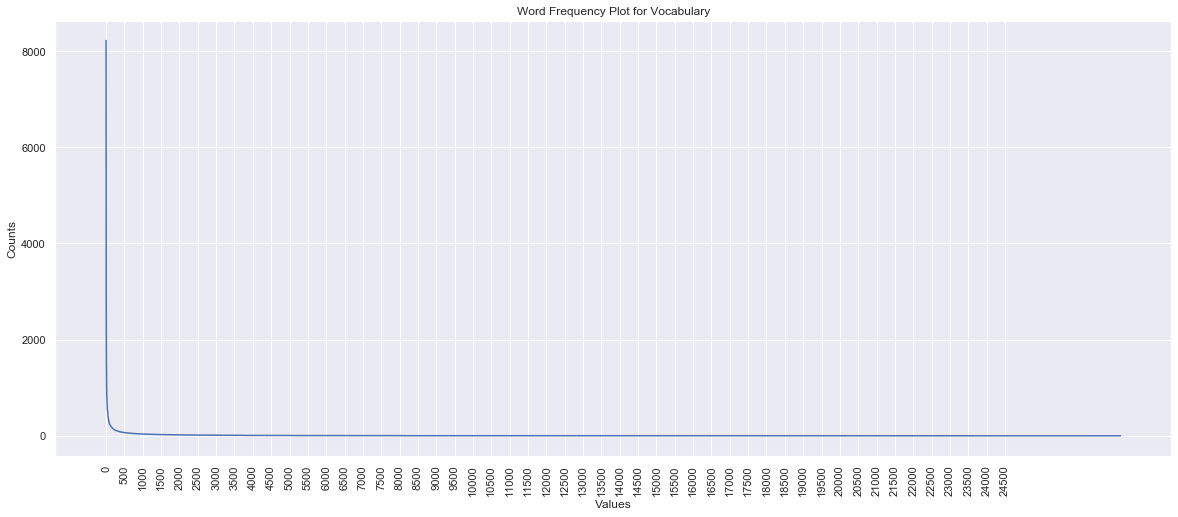

In [55]:
keys=[]
values=[]
for i, j in word_frequency_sort:
    keys.append(i)
    values.append(j)
plt.figure(figsize=(20,8))
plt.title('Word Frequency Plot for Vocabulary')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.xticks(np.arange(0,25000,500), rotation=90)
plt.plot(values)
plt.show()

<font color='blue'>*** Observe that less than 2% of words in vocabulary is more frequent than rest***</font>

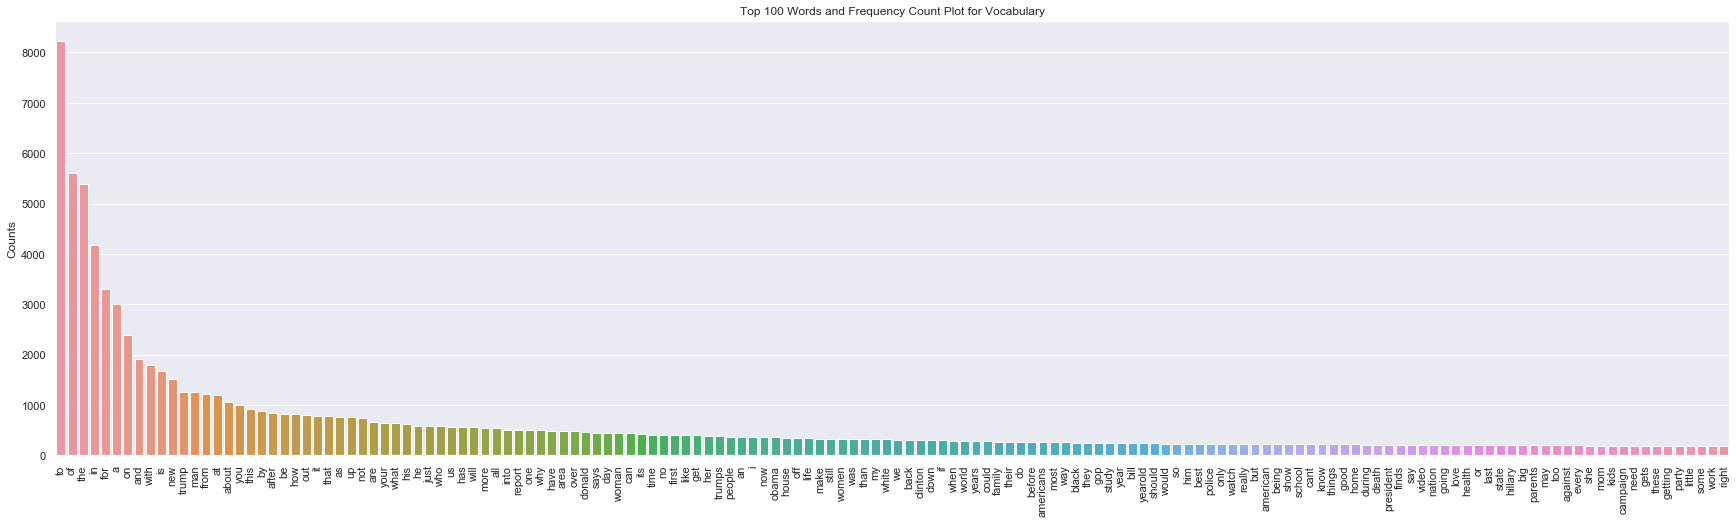

In [56]:
plt.figure(figsize=(30,8))
plt.title('Top 100 Words and Frequency Count Plot for Vocabulary')
plt.ylabel('Counts')
plt.xticks(rotation=90)
sns.barplot(x=keys[:150],y=values[:150])
plt.show()

## Word Embedding

### Get Glove Word Embeddings

In [57]:
#glove_file=project_path + "glove.6B.zip"

In [58]:
#Extract Glove embedding zip file
#from zipfile import ZipFile
#with ZipFile(glove_file, 'r') as z:
#  z.extractall()

<font color='blue'>*** Already I've downloaded and extracted GloVe word embeddings, will be using it. So skipping above steps ***</font>

### Get the Word Embeddings using Embedding file as given below.

In [59]:
filename='C:/Users/Venkatesh K Govindan/PGP-AIML/Project/Residency-10/Data/glove.6B/glove.6B.200d.txt'
embedding_dim=200
embedding_dict={}
with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:], "float32")
        embedding_dict[word]=vector
f.close()
print('Found %s word vectors.' %len(embedding_dict))

Found 400000 word vectors.


### Create a weight matrix for words in training docs

In [60]:
embedding_matrix=np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector=embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

<font color='blue'> Embedding dimensions </font>

In [61]:
embedding_matrix.shape

(27655, 200)

### Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [62]:
input_layer=Input(shape=(maxlen,),dtype=tf.int64)
embed=Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False)(input_layer)
lstm=Bidirectional(LSTM(128),merge_mode='concat')(embed)
drop1=Dropout(0.3)(lstm)
dense1=Dense(128,activation='relu')(drop1)
drop2=Dropout(0.3)(dense1)
dense2=Dense(64,activation='relu')(drop2)
output_layer=Dense(2,activation='softmax')(dense2)
model=Model(input_layer,output_layer)

Instructions for updating:
Colocations handled automatically by placer.


<font color='blue'>*** Turned off trainable parameter for embedding layer, since GloVe word vector is used *** </font>

In [63]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 240, 200)          5531000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256

In [64]:
from keras.optimizers import Adam, SGD
from keras.losses import sparse_categorical_crossentropy

optimizer=Adam(learning_rate=0.001)
#optimizer=Adam(learning_rate=0.0001)
#optimizer=SGD(learning_rate=0.0001)
model.compile(loss=sparse_categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

In [65]:
# define checkpoint callback
#filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# define earlystopping callback
early_stopping=EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3, verbose=1, restore_best_weights=True)

### Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

<font color='blue'>*** Data is split into 80:20 ratio for training and prediction; while training, 20% of data is considered for validation***</font> 

In [67]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'validation'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()

In [68]:
batch_size=100
epochs=25

In [69]:
model_fit1=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping], verbose=True)

Train on 17093 samples, validate on 4274 samples
Epoch 1/25
17093/17093 [==============================] - 75s 4ms/step - loss: 0.6107 - accuracy: 0.6638 - val_loss: 0.5348 - val_accuracy: 0.7553
Epoch 2/25
17093/17093 [==============================] - 73s 4ms/step - loss: 0.4645 - accuracy: 0.7797 - val_loss: 0.4625 - val_accuracy: 0.7871
Epoch 3/25
17093/17093 [==============================] - 74s 4ms/step - loss: 0.3817 - accuracy: 0.8314 - val_loss: 0.3780 - val_accuracy: 0.8365
Epoch 4/25
17093/17093 [==============================] - 76s 4ms/step - loss: 0.3294 - accuracy: 0.8613 - val_loss: 0.3655 - val_accuracy: 0.8463
Epoch 5/25
17093/17093 [==============================] - 72s 4ms/step - loss: 0.3001 - accuracy: 0.8714 - val_loss: 0.3518 - val_accuracy: 0.8498
Epoch 6/25
17093/17093 [==============================] - 72s 4ms/step - loss: 0.2660 - accuracy: 0.8907 - val_loss: 0.3551 - val_accuracy: 0.8510
Epoch 7/25
17093/17093 [==============================] - 73s 4ms/ste

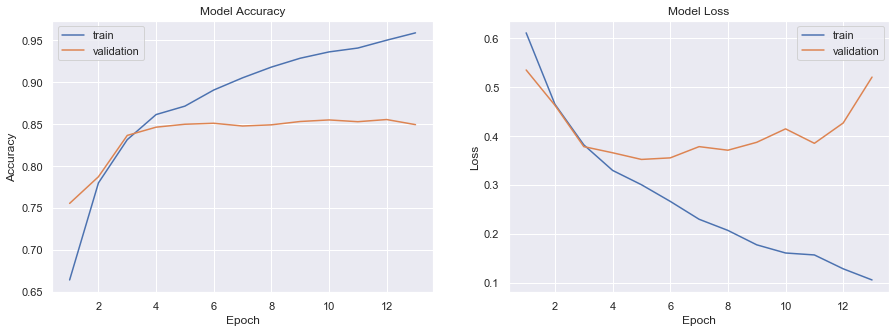

In [70]:
plot_model_history(model_fit1)

<font color='blue'> *** Model's performance was consistant across train and validation, but observe sudden spike in validation loss after Epoch 8***</font>

In [71]:
#from keras.models import load_model
#filename='model-ep008-loss0.307-val_loss0.357.h5'
#model=load_model(filename)

<font color='blue'>*** Evaluating model's performance with full train dataset***</font>

In [72]:
train_score=model.evaluate(X_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

21367/21367 [==============================] - 116s 5ms/step
Train loss: 0.16586773682556719
Train accuracy: 0.9407965540885925


<font color='blue'>*** Predicting model's performance with test dataset and converting prediction propabilities into actual values***</font>

In [73]:
y_pred=model.predict(np.array(X_test), verbose=0)

In [74]:
print(y_pred)

[[9.7892911e-04 9.9902105e-01]
 [9.9993289e-01 6.7087887e-05]
 [9.9112457e-01 8.8753598e-03]
 ...
 [9.9867342e-05 9.9990010e-01]
 [2.5869146e-01 7.4130857e-01]
 [9.9955481e-01 4.4517004e-04]]


In [75]:
y_pred=[1 if j>i else 0 for i,j in y_pred]

In [76]:
print(y_pred)

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 

<font color='blue'>*** Evaluating model's prediction performance with confusion matrix and classification report ***</font>

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2599,  432],
       [ 321, 1990]], dtype=int64)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3031
           1       0.82      0.86      0.84      2311

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



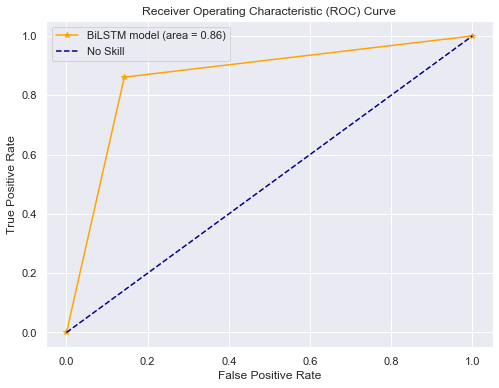

In [79]:
from sklearn.metrics import roc_curve,roc_auc_score
roc_auc=roc_auc_score(y_test, y_pred)
roc_fpr, roc_tpr, roc_thresholds = roc_curve(y_test, y_pred)
plt.plot(roc_fpr, roc_tpr, marker='*', label='BiLSTM model (area = %0.2f)' % roc_auc, color='orange')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='No Skill') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Conclusion:
##### Tried different options while building/training this DNN model for Sarcasm Detection usecase
* with/without stopwords, lemmatization while creating vocabulary 
* different optimizers and changing those learing rate
* different epochs and controlling the train with callbacks

##### Best training accuracy was 95.89%, validation accuracy was 85.54% and prediction accuracy was 86%.